# Analyze parameters in summary_optuna

**Motivation:** Having file summary_optuna with all optuna reuslts, this file aims to analyze all these results (in terms of number of parameters)

### loads

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

# local
import set_path
import supp.support_load as ls
from supp.support_save import save_df
from supp.support_model_glm import get_model_coef_df, get_model_coef_dict

In [4]:
summary_optuna_v1 = ls.read_excel('summary_optuna_v1_mod')['optuna_results']
summary_optuna_v2 = ls.read_excel('summary_optuna_v2_mod')['optuna_results']

# drop models that reached max epoch
max_epoch = 1000
summary_optuna_v1 = summary_optuna_v1[summary_optuna_v1['epoch']!=max_epoch]
summary_optuna_v2 = summary_optuna_v2[summary_optuna_v2['epoch']!=max_epoch]


print(f'{summary_optuna_v1.shape}\t shape of summary_optuna_v1')
print(f'{summary_optuna_v2.shape}\t shape of summary_optuna_v2')

Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\summary_optuna_v1_mod.xlsx
Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\summary_optuna_v2_mod.xlsx
(1741, 24)	 shape of summary_optuna_v1
(1848, 24)	 shape of summary_optuna_v2


In [5]:
# Get dataframe with all GLM coefficients
df_coef_v1 = get_model_coef_df()
# Get feature names for each GLM model
coef_step_v1 = get_model_coef_dict('step_glm', df=df_coef_v1)
coef_lasso_v1 = get_model_coef_dict('lasso_glm', df=df_coef_v1)
coef_ridge_v1 = get_model_coef_dict('ridge_glm', df=df_coef_v1)

Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\summary_model_coefficients_v0.xlsx


In [6]:
summary_optuna_v1.head(2)

,model name,model modification,model param,type,trial,time_id,n_layers,layer_1,layer_2,layer_3,...,epoch,mean,mean_vizier,mean_non_vizier,bottom_3th_vizier,top_3th_non_vizier,viziers_above_overlap,viziers_in_overlap,non_viziers_in_overlap,persons_in_overlap
0,step,small,mse,step_small_mse,42,2025032112554070,3,10,42.0,42.0,...,89.6,0.022370,0.659759,0.009006,0.396573,0.401127,8.0,5.4,10.0,15.4
1,step,small,mse,step_small_mse,39,2025032112531800,3,10,42.0,42.0,...,87.4,0.023099,0.649999,0.009950,0.383015,0.398460,8.6,4.8,10.2,15.0


In [7]:
summary_optuna_v2.head(2)

,model name,model modification,model param,type,trial,time_id,n_layers,layer_1,layer_2,layer_3,...,epoch,mean,mean_vizier,mean_non_vizier,bottom_3th_vizier,top_3th_non_vizier,viziers_above_overlap,viziers_in_overlap,non_viziers_in_overlap,persons_in_overlap
0,step,do,03,step_do_03,0,2025032202424190,1,26,NaN,NaN,...,303.8,0.019295,0.620972,0.006753,0.331218,0.278829,6.6,6.8,266.0,272.8
1,step,do,03,step_do_03,1,2025032202455080,2,42,42.0,NaN,...,32.0,0.020026,0.639416,0.007129,0.344973,0.238871,7.0,6.4,274.2,280.6


In [8]:
# Get dataframe with all GLM coefficients
df_coef_v2 = get_model_coef_df(version='_v2')
# Get feature names for each GLM model
coef_step_v2 = get_model_coef_dict('step_glm', df=df_coef_v2)
coef_lasso_v2 = get_model_coef_dict('lasso_glm', df=df_coef_v2)
coef_ridge_v2 = get_model_coef_dict('ridge_glm', df=df_coef_v2)

Excel file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\summary_model_coefficients_v0_v2.xlsx


In [9]:
input_size_v1 = {
    'step': len(coef_step_v1) - 1,
    'lasso': len(coef_lasso_v1) - 1,
    'ridge': len(coef_ridge_v1) - 1,
}
input_size_v2 = {
    'step': len(coef_step_v2) - 1,
    'lasso': len(coef_lasso_v2) - 1,
    'ridge': len(coef_ridge_v2) - 1
}
print(f'{input_size_v1=}')
print(f'{input_size_v2=}')

input_size_v1={'step': 4, 'lasso': 9, 'ridge': 40}
input_size_v2={'step': 11, 'lasso': 17, 'ridge': 60}


In [10]:
summary_optuna_v1['input_size'] = summary_optuna_v1['model name'].map(input_size_v1)
summary_optuna_v2['input_size'] = summary_optuna_v2['model name'].map(input_size_v2)

### functions

In [11]:
def count_neural_network_parameters(input_size, hidden_layers):
    """
    Calculate the total number of parameters in a neural network.
    
    Parameters:
    input_size (int): Number of input features.
    hidden_layers (list of int): List containing sizes of hidden layers.

    Returns:
    int: Total number of parameters in the network.
    """
    total_params = 0
    
    # First layer (input to first hidden layer)
    total_params += (input_size * hidden_layers[0]) + hidden_layers[0]
    
    # Hidden layers
    for i in range(len(hidden_layers) - 1):
        total_params += (hidden_layers[i] * hidden_layers[i+1]) + hidden_layers[i+1]
    
    # Output layer (last hidden layer to output neuron)
    total_params += (hidden_layers[-1] * 1) + 1  # One output neuron
    
    return int(total_params)

In [12]:
def calc_nn_params(row):
    columns = ['layer_1', 'layer_2', 'layer_3']
    n_layers = row['n_layers']
    input_size = row['input_size']
    hidden_layers = list(row[columns[:n_layers]])
    n_params = count_neural_network_parameters(input_size, hidden_layers)
    return n_params

In [13]:
def add_quantile_bins(df, column, q):
    """
    Add a 'bins' column to the DataFrame, assigning each value in the specified column
    to quantile-based bins with range labels.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column (str): The column to bin.
    q (int): The number of quantile-based bins.

    Returns:
    pd.DataFrame: The DataFrame with an added 'bins' column.
    """
    # Create quantile-based bins and get bin edges
    bins, bin_edges = pd.qcut(df[column], q=q, retbins=True, duplicates='drop')
    
    # Convert bin edges into range labels
    bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]
    
    # Assign bins with custom labels
    df[f'{column}_bins'] = pd.qcut(df[column], q=q, labels=bin_labels, duplicates='drop')
    
    return df

In [14]:
def plot_ordered_heatmap(df, bin1, bin2, value_col):
    """
    Orders the bins based on their numerical range and plots a heatmap where the values represent the mean of a specified column.
    
    Parameters:
    df: DataFrame containing the data.
    bin1: Column name representing the first categorical bin.
    bin2: Column name representing the second categorical bin.
    value_col: Column name whose mean values will be displayed in the heatmap.
    """
    def extract_lower_bound(bin_label):
        """
        Extract the lower bound of bin ranges.
        If no '-' is found, return the whole number.
        """
        bin_label = bin_label.decode() if isinstance(bin_label, bytes) else bin_label  # Ensure string format
        match = re.match(r"(\d+)-", bin_label)
        return int(match.group(1)) if match else int(bin_label)
    
    # Ensure all values in bin1 and bin2 are strings
    df[bin1] = df[bin1].astype(str)
    df[bin2] = df[bin2].astype(str)
    
    # Sort bin labels based on their numeric range
    sorted_bin1 = sorted(df[bin1].unique(), key=extract_lower_bound)
    sorted_bin2 = sorted(df[bin2].unique(), key=extract_lower_bound)
    
    # Create a pivot table to calculate the mean values for each (bin1, bin2) pair
    heatmap_data = df.pivot_table(index=bin1, columns=bin2, values=value_col, aggfunc='mean')
    
    # Reorder the index and columns to match sorted bins
    heatmap_data = heatmap_data.reindex(index=sorted_bin1, columns=sorted_bin2)
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f")
    
    plt.xlabel(bin2)
    plt.ylabel(bin1)
    plt.title("Ordered Heatmap of {} vs {} (Mean of {})".format(bin1, bin2, value_col))
    plt.show()

### calc parameters

In [15]:
summary_optuna_v1['n_parameters'] = summary_optuna_v1.apply(calc_nn_params, axis=1)
summary_optuna_v2['n_parameters'] = summary_optuna_v2.apply(calc_nn_params, axis=1)
summary_optuna_v1.head()

,model name,model modification,model param,type,trial,time_id,n_layers,layer_1,layer_2,layer_3,...,mean_vizier,mean_non_vizier,bottom_3th_vizier,top_3th_non_vizier,viziers_above_overlap,viziers_in_overlap,non_viziers_in_overlap,persons_in_overlap,input_size,n_parameters
0,step,small,mse,step_small_mse,42,2025032112554070,3,10,42.0,42.0,...,0.659759,0.009006,0.396573,0.401127,8.0,5.4,10.0,15.4,4,2361
1,step,small,mse,step_small_mse,39,2025032112531800,3,10,42.0,42.0,...,0.649999,0.009950,0.383015,0.398460,8.6,4.8,10.2,15.0,4,2361
2,step,small,mse,step_small_mse,44,2025032112573280,3,10,42.0,34.0,...,0.652829,0.009300,0.377589,0.405560,8.0,5.4,10.2,15.6,4,2009
3,step,small,mse,step_small_mse,38,2025032112523380,3,10,42.0,42.0,...,0.665312,0.010038,0.413206,0.403798,7.6,5.8,10.2,16.0,4,2361
4,step,small,mse,step_small_mse,41,2025032112545610,3,10,42.0,42.0,...,0.665654,0.012084,0.441900,0.407162,8.6,4.8,10.2,15.0,4,2361


### analyze

In [16]:
q=5
# Create q quantile-based bins
summary_optuna_v1 = add_quantile_bins(summary_optuna_v1, 'n_parameters', q)
summary_optuna_v2 = add_quantile_bins(summary_optuna_v2, 'n_parameters', q)
summary_optuna_v1 = add_quantile_bins(summary_optuna_v1, 'persons_in_overlap', q)
summary_optuna_v2 = add_quantile_bins(summary_optuna_v2, 'persons_in_overlap', q)
summary_optuna_v1.head()

,model name,model modification,model param,type,trial,time_id,n_layers,layer_1,layer_2,layer_3,...,bottom_3th_vizier,top_3th_non_vizier,viziers_above_overlap,viziers_in_overlap,non_viziers_in_overlap,persons_in_overlap,input_size,n_parameters,n_parameters_bins,persons_in_overlap_bins
0,step,small,mse,step_small_mse,42,2025032112554070,3,10,42.0,42.0,...,0.396573,0.401127,8.0,5.4,10.0,15.4,4,2361,2009-5377,0-15
1,step,small,mse,step_small_mse,39,2025032112531800,3,10,42.0,42.0,...,0.383015,0.398460,8.6,4.8,10.2,15.0,4,2361,2009-5377,0-15
2,step,small,mse,step_small_mse,44,2025032112573280,3,10,42.0,34.0,...,0.377589,0.405560,8.0,5.4,10.2,15.6,4,2009,1403-2009,0-15
3,step,small,mse,step_small_mse,38,2025032112523380,3,10,42.0,42.0,...,0.413206,0.403798,7.6,5.8,10.2,16.0,4,2361,2009-5377,15-22
4,step,small,mse,step_small_mse,41,2025032112545610,3,10,42.0,42.0,...,0.441900,0.407162,8.6,4.8,10.2,15.0,4,2361,2009-5377,0-15


### plot heatmap

In [17]:
summary_optuna_v1['n_parameters_bins'].value_counts()

n_parameters_bins
291-819      360
13-291       350
1403-2009    348
2009-5377    345
819-1403     338
Name: count, dtype: int64

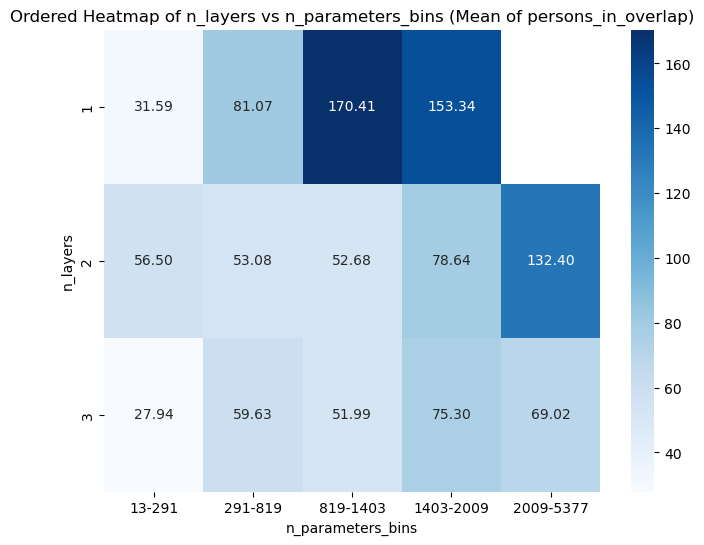

In [18]:
plot_ordered_heatmap(summary_optuna_v1, 'n_layers', 'n_parameters_bins', 'persons_in_overlap')

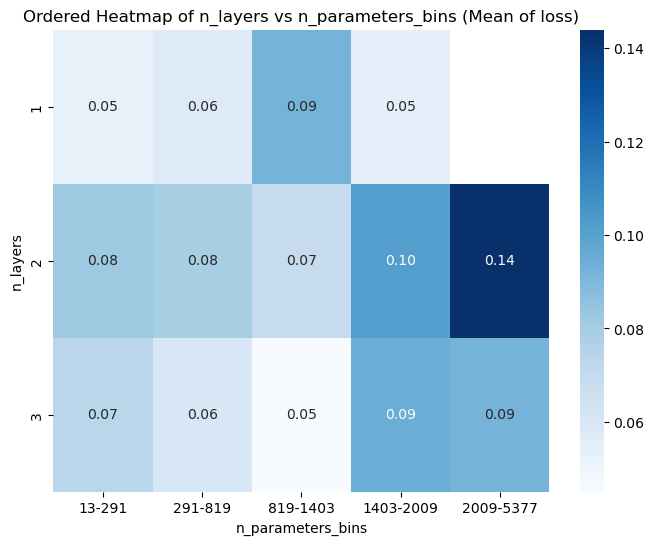

In [19]:
plot_ordered_heatmap(summary_optuna_v1, 'n_layers', 'n_parameters_bins', 'loss')

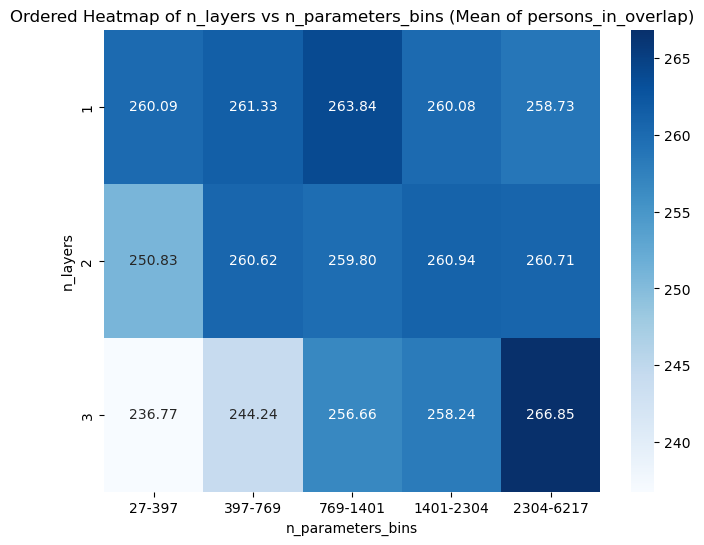

In [20]:
plot_ordered_heatmap(summary_optuna_v2, 'n_layers', 'n_parameters_bins', 'persons_in_overlap')